## Importamos librerias

In [5]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Parámetros de visualización
sns.set_context('talk')
mpl.rcParams['figure.figsize'] = (8, 6)


import os

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx

from glob import glob
from pathlib import Path

# Los datos

Bajamos y revisamos el dataset

Utilizar el signo de exclamación permite correr comandos como si fuera la terminal de la computadora. Podemos utilizarlo para descargar (wget) o descomprimir (unzip) archivos, y también para instalar librerías de python (pip install) entre otras.

In [ ]:
!wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
!unzip -q DataSujetos
!wget -q -O aal_extended_withCoords.csv https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws&dl=1

### Atlas
Son 116 regiones cerebrales
La columna "1" indica el nombre de la subregión, la columna "3" indica a qué región cerebral pertenece, la columna "4" en qué hemisferio se localiza (L=izquierda, R=derecha, --= está en la línea media), las columnas "5", "6" y "7" indican las coordenadas x, y, z de cada subregión

In [7]:
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]
RegionsNames

,1,2,3,4,5,6,7
0,Precentral_L,2001,Central,L,-39,-6,51
1,Precentral_R,2002,Central,R,41,-8,52
2,Frontal_Sup_L,2101,Frontal,L,-18,35,42
3,Frontal_Sup_R,2102,Frontal,R,22,31,44
4,Frontal_Sup_Orb_L,2111,Frontal,L,-17,47,-13
...,...,...,...,...,...,...,...
111,Vermis_6,9130,Cerebelum,--,2,-67,-15
112,Vermis_7,9140,Cerebelum,--,2,-72,-25
113,Vermis_8,9150,Cerebelum,--,2,-64,-34
114,Vermis_9,9160,Cerebelum,--,2,-55,-35


## Lista de archivos
Tenemos varios sujetos para 4 condiciones, una correspondiente a vigilia y 3 a diferentes estadios del sueño no REM (*rapid eye movement*):<br>

"W": despierto ("Wake")
<br> "N1": sueño "leve"
<br>"N2": sueño "intermedio"
<br>"N3": sueño "profundo"

In [8]:
files = os.listdir('DataSujetos/')
files

['N3_suj18.csv',
 'N2_suj8.csv',
 'N3_suj8.csv',
 'N3_suj9.csv',
 'N2_suj9.csv',
 'W_suj18.csv',
 'W_suj1.csv',
 'N1_suj10.csv',
 'N1_suj7.csv',
 'N2_suj18.csv',
 'N1_suj6.csv',
 'N1_suj11.csv',
 'W_suj2.csv',
 'N1_suj13.csv',
 'N1_suj4.csv',
 'N1_suj5.csv',
 'N1_suj12.csv',
 'W_suj3.csv',
 'W_suj7.csv',
 'N1_suj1.csv',
 'N1_suj16.csv',
 'N1_suj17.csv',
 'W_suj6.csv',
 'W_suj4.csv',
 'N1_suj2.csv',
 'N1_suj15.csv',
 'N1_suj14.csv',
 'N1_suj3.csv',
 'W_suj5.csv',
 'W_suj8.csv',
 'N2_suj11.csv',
 'N2_suj10.csv',
 'N1_suj18.csv',
 'W_suj9.csv',
 'N2_suj12.csv',
 'N2_suj13.csv',
 'N1_suj8.csv',
 'N2_suj17.csv',
 'N2_suj16.csv',
 'N1_suj9.csv',
 'N2_suj14.csv',
 'N2_suj15.csv',
 'N3_suj11.csv',
 'W_suj17.csv',
 'N2_suj2.csv',
 'N3_suj2.csv',
 'N3_suj3.csv',
 'N2_suj3.csv',
 'W_suj16.csv',
 'N3_suj10.csv',
 'N3_suj12.csv',
 'W_suj14.csv',
 'N3_suj1.csv',
 'N2_suj1.csv',
 'W_suj15.csv',
 'N3_suj13.csv',
 'N3_suj17.csv',
 'W_suj11.csv',
 'N3_suj4.csv',
 'N2_suj4.csv',
 'N2_suj5.csv',
 'N3_suj5

Obtener archivos correspondientes a la condición "W" unicamente:

In [11]:
filenames = Path('DataSujetos').glob('W_*.csv')
next(filenames)

PosixPath('DataSujetos/W_suj18.csv')

## Vamos a analizar el sujeto 1 de la condición W
Levantamos los datos y los transformamos en una matriz de adyacencia pesada, donde le quitamos los valores de la diagonal (las auto correlaciones de cada nodo)

In [17]:
filename = 'DataSujetos/W_suj1.csv'
df = pd.read_csv(filename, header=None)

# Toma los valores del dataframe y crea un Numpy Array (sin índices ni nombres de fila o columna)
matAdyacPesada = df.values
# Dado que cada array es cuadrado, obtiene número de filas ó columnas
n = matAdyacPesada.shape[0]

# np.diag(np.ones(n)) forma un matriz cuadrada con 1 en la diagonal y cero en todos los demás lugares
# luego, lo que hacemos acá es restar a la matriz original una diagonal con unos. De ese modo me libero de tener todos unos 
# en la matriz original
matAdyacPesada -= np.diag(np.ones(n))

# Muestra que cada CSV es la matriz de adyacencia para cada sujeto en el estado especificado
# La red se forma con las neuronas y sus conexiones. Es una red ponderada
print(df.head()) 

       0        1        2        3        4        5        6        7    \
0  0.00000  0.69976  0.61289  0.62648  0.59260  0.68651  0.68221  0.62131   
1  0.69976  0.00000  0.42445  0.43383  0.41214  0.51148  0.40182  0.44451   
2  0.61289  0.42445  0.00000  0.79685  0.54559  0.58222  0.82812  0.68815   
3  0.62648  0.43383  0.79685  0.00000  0.57511  0.75537  0.75331  0.93048   
4  0.59260  0.41214  0.54559  0.57511  0.00000  0.80216  0.56573  0.61385   

       8        9    ...       106      107       108      109      110  \
0  0.56840  0.48871  ... -0.185450  0.46122  0.271640  0.58280  0.74734   
1  0.29535  0.29000  ... -0.028403  0.17453  0.218010  0.33058  0.41821   
2  0.42913  0.42463  ...  0.008060  0.42016  0.047651  0.47261  0.58051   
3  0.45229  0.50021  ... -0.183630  0.52827  0.063812  0.46052  0.71970   
4  0.62128  0.65266  ... -0.389000  0.34667  0.040996  0.61121  0.60078   

       111      112      113      114      115  
0  0.64056  0.61845  0.67543  0.48864

Graficamos la matriz de ayacencia pesada

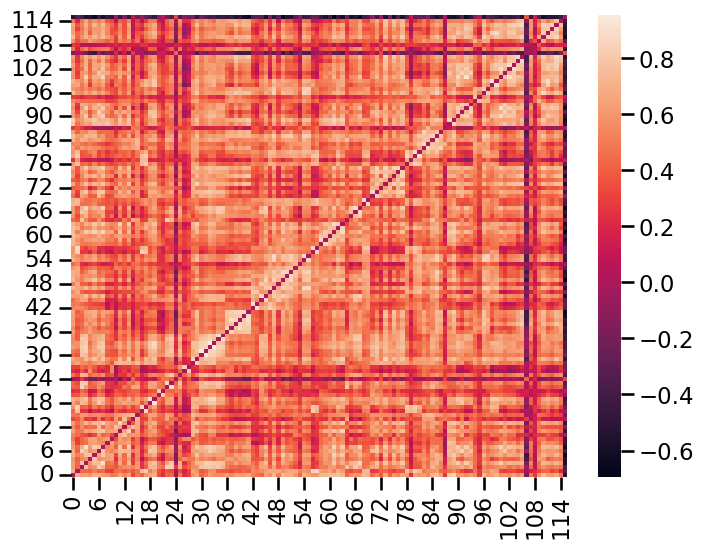

In [18]:
# Crear un heatmap con la matriz de adyacencia
sns.heatmap(matAdyacPesada)
# Setear los límites del gráfico para mostrar toda la matriz y nada más
plt.xlim(0, n)
plt.ylim(0, n)

plt.show()

Le ponemos un umbral "th" para binarizarla hacia una matriz de adyacencia no pesada:

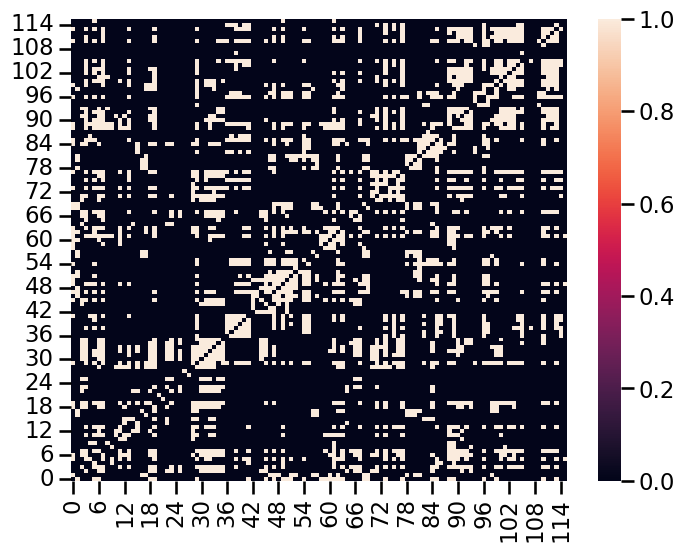

In [20]:
th = 0.65 # Podemos variar este umbral
matAdyacNoPesada = np.abs(matAdyacPesada) >= th # Binarizamos utilizando una condicion booleana
# Recordemos que 1 es equivalente a True y 0 a False en Python

sns.heatmap(matAdyacNoPesada)
plt.xlim(0, n)
plt.ylim(0, n)

plt.show()

# NetworkX

Creamos un grafo con la librería Networkx a partir de la matriz.
Vemos si se trata de un grafo conectado

In [21]:
G = nx.from_numpy_array(matAdyacNoPesada)
print('Es conectado?:', nx.is_connected(G))

Es conectado?: False


## Visualizaciones
Graficamos al grafo con los nodos dispuestos de diferentes formas

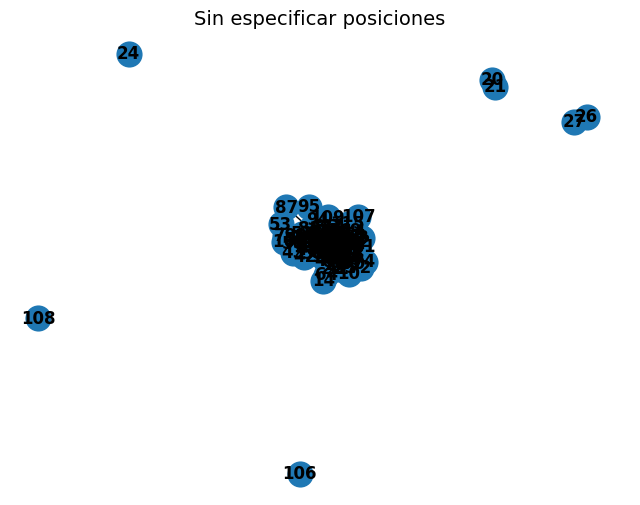

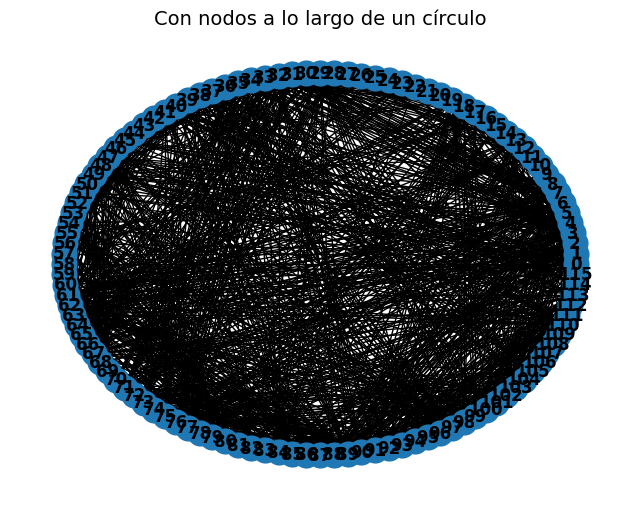

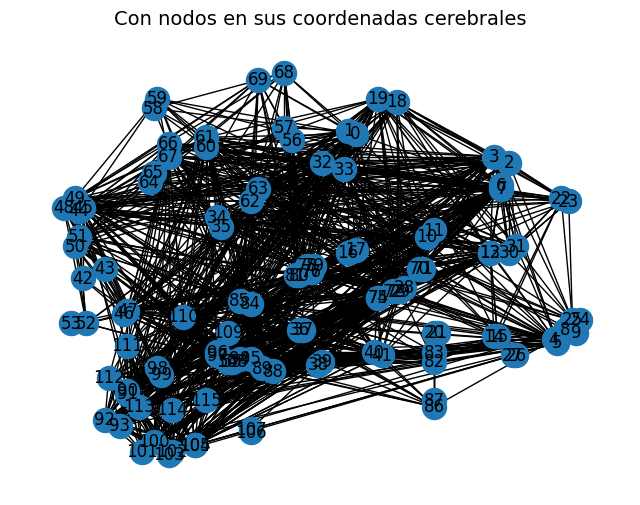

In [24]:
# EL parámetro layout indica como se disponen los nodos. 
plt.figure(figsize=(8, 6))
plt.title('Sin especificar posiciones', fontsize=14)
nx.draw(G, with_labels=True, font_weight='bold')

plt.figure(figsize=(8, 6))
plt.title('Con nodos a lo largo de un círculo', fontsize=14)
layout = nx.circular_layout(G)
nx.draw(G, layout, with_labels=True, font_weight='bold')

# Observemos que estamos utilizando las coordenadas y, z. Esto equivale a ver el cerebro "de costado"
plt.figure(figsize=(8, 6))
plt.title('Con nodos en sus coordenadas cerebrales', fontsize=14)
# En el código siguiente pasan varias cosas: 
# np.array([RegionsNames[6].values, RegionsNames[7].values]): Forma una matriz con los valores de las columnas 6 y 7 (y, z)
# .T : la matriz se transpone para que quede arreglada por columnas: una col para y, otra para z
# zip() crea un índice para cada fila de la matriz
# Convierte en diccionario. Queda algo así: {0: array([-6, 51]), 1: array([-8, 52]),..., 115: array([-46, -32])}
layout = dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
nx.draw(G, layout, with_labels=True, linewidths=1)

plt.show()

### Graficamos el grafo con cada nodo coloreado de acuerdo a su grado (cantidad de enlaces que posee)

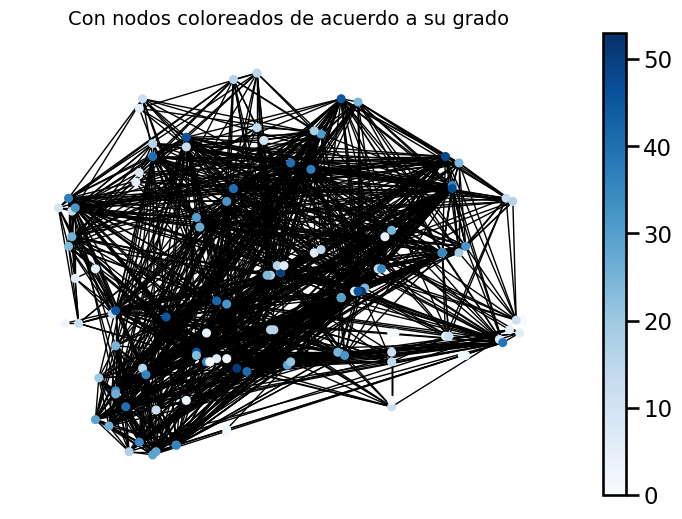

In [ ]:
degrees = G.degree() # Diccionario con ID de nodo y su grado
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

layout = dict(zip(range(n), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
vmin = min(n_color)
vmax = max(n_color)
cmap = plt.cm.Blues
norm = plt.Normalize(vmin = vmin, vmax=vmax)

plt.figure(figsize=(9,6))
plt.title('Con nodos coloreados de acuerdo a su grado', fontsize=14)
nx.draw(G, layout, node_size=25, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=plt.gca())

plt.show()

Cuál es el nodo con más enlaces?

In [ ]:
sortedNodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
print(f'El nodo con mayor grado es el {sortedNodes[0][0]}, que posee {sortedNodes[0][1]} enlaces' )

El nodo con mayor grado es el 29, que posee 53 enlaces


# Comparemos dos estados de vigila

In [ ]:
filename = '/content/DataSujetos/W_suj1.csv'
df = pd.read_csv(filename, header=None)
matAdyacPesadaWake = df.values
n = matAdyacPesadaWake.shape[0]
matAdyacPesadaWake -= np.diag(np.ones(n))

filename = '/content/DataSujetos/N3_suj1.csv'
df = pd.read_csv(filename, header=None)
matAdyacPesadaSleep = df.values
n = matAdyacPesadaSleep.shape[0]
matAdyacPesadaSleep -= np.diag(np.ones(n))

Como observamos ambos estados están asociados a diferentes niveles de correlación entre áreas. ¿Cómo compararlos?

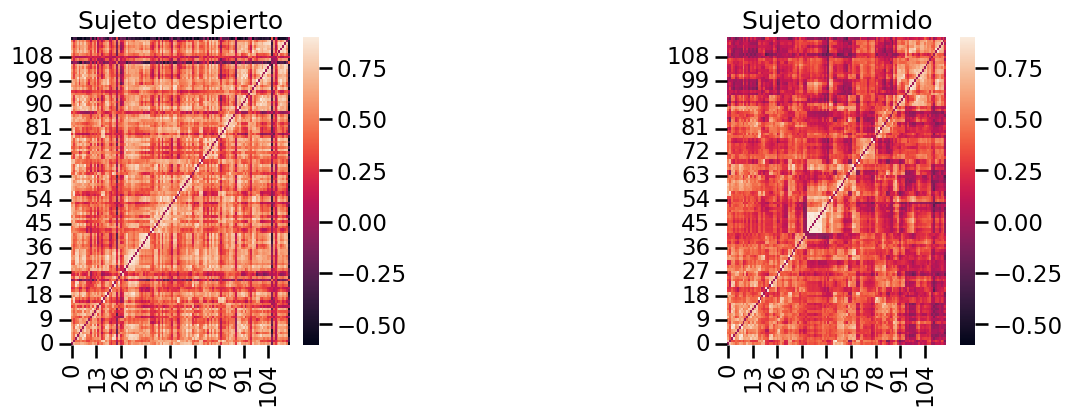

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(131)
sns.heatmap(matAdyacPesadaWake, vmin=-.6, vmax=.9)
plt.xlim(0, n)
plt.ylim(0, n)
plt.title('Sujeto despierto')

plt.subplot(133)
sns.heatmap(matAdyacPesadaSleep, vmin=-.6, vmax=.9)
plt.xlim(0, n)
plt.ylim(0, n)
plt.title('Sujeto dormido')

plt.show()

##MUY ÚTIL: Definamos una función para binarizar una matriz de adyacencia pesada en función de a densidades de enlances resultantes

In [ ]:
def density_to_th(W, d):
    n = W.shape[0]
    tril_idx = np.tril_indices(n, -1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

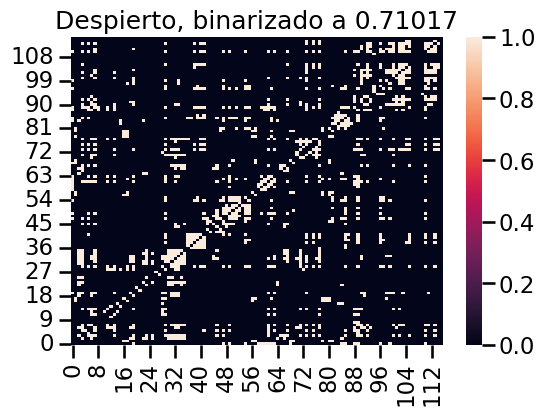

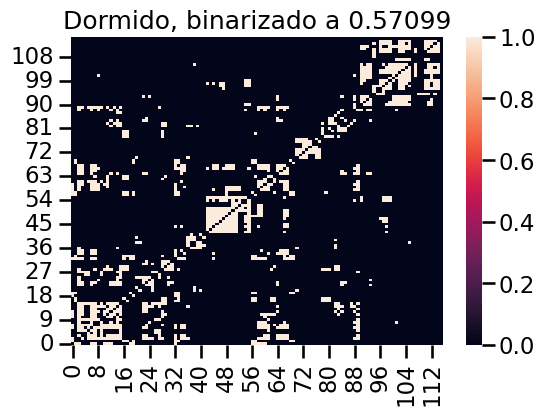

In [ ]:
densidad=0.1 # comparemos ambos estados con una densidad de enlaces de 10%

plt.figure(figsize=(6, 4))

thWake = density_to_th(matAdyacPesadaWake, densidad)
sns.heatmap(matAdyacPesadaWake >= thWake)
plt.xlim(0,n)
plt.ylim(0,n);
plt.title(f'Despierto, binarizado a {thWake}')
plt.show()

plt.figure(figsize=(6,4))
thSleep = density_to_th(matAdyacPesadaSleep, densidad)
sns.heatmap(matAdyacPesadaSleep >= thSleep)
plt.xlim(0,n)
plt.ylim(0,n);
plt.title(f'Dormido, binarizado a {thSleep}')

plt.show()

## ¿Y la distribución de grados en ambos casos?

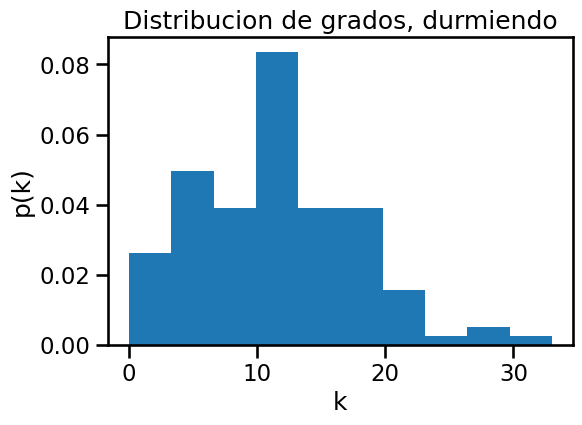

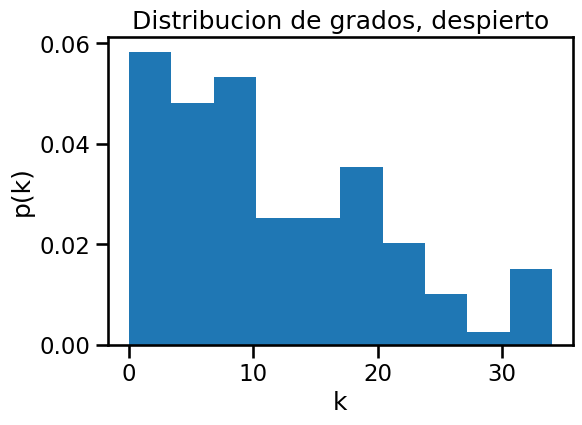

In [ ]:
plt.figure(figsize=(6, 4))
Gsleep = nx.from_numpy_array(matAdyacPesadaSleep >= thSleep)
degreesSleep = [Gsleep.degree(n) for n in Gsleep.nodes()]
histSleep, binsSleep, _ = plt.hist(degreesSleep, bins=10, density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, durmiendo')


plt.figure(figsize=(6, 4))
Gwake = nx.from_numpy_array(matAdyacPesadaWake >= thWake)
degreesWake = [Gwake.degree(n) for n in Gwake.nodes()]
histWake, binsWake, _ = plt.hist(degreesWake, bins=10, density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, despierto')

plt.show()

Ahora en escala LOG-LOG

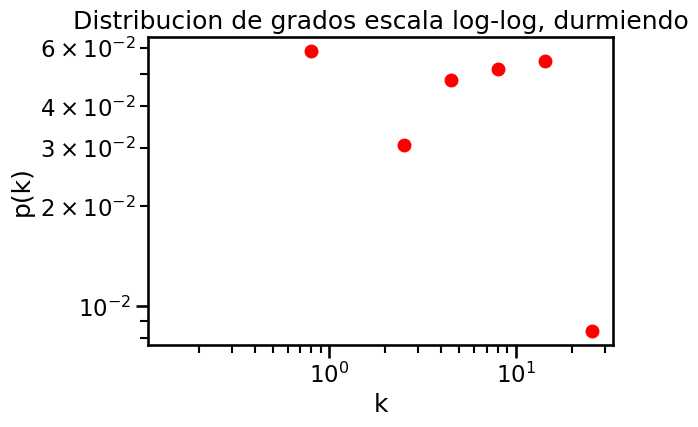

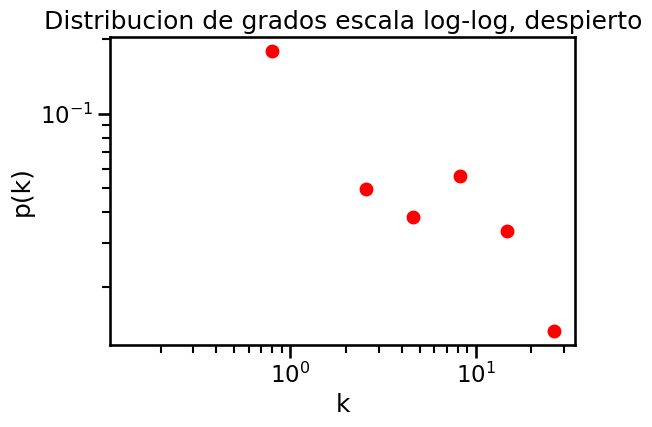

In [ ]:
plt.figure(figsize=(6, 4))
logbinsSleep = np.logspace(np.log10(binsSleep[0]+.1), np.log10(binsSleep[-1]+.1), len(binsSleep))
histSleepLog, logbinsSleep, _ = plt.hist(degreesSleep, bins=logbinsSleep, density=True, log=True)
plt.clf()
x = (logbinsSleep[:-1] + logbinsSleep[1:]) / 2
plt.plot(x,histSleepLog,'ro')
plt.xlabel('k')
plt.ylabel('p(k)')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribucion de grados escala log-log, durmiendo')

plt.figure(figsize=(6, 4))
logbinsWake = np.logspace(np.log10(binsWake[0]+.1), np.log10(binsWake[-1]+.1), len(binsWake))
histWakeLog, logbinsWake, _ = plt.hist(degreesWake, bins=logbinsWake, density=True, log=True)
plt.clf()
x = (logbinsWake[:-1] + logbinsWake[1:]) / 2
plt.plot(x, histWakeLog,'ro')
plt.xlabel('k')
plt.ylabel('p(k)')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribucion de grados escala log-log, despierto')

plt.show()